<a href="https://colab.research.google.com/github/hapisssss/spesial/blob/main/Kode_Program_Kelompok_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Liblary

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import resnet101
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score,
    recall_score, precision_score, confusion_matrix
)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

##Import Data

In [ ]:
!mkdir -p ~/.kaggle
!echo '{"username":"hafizhsatriabuana","key":"718b4d61d05c11ed985d4d57e17f30b6"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images

!unzip alzheimers-dataset-4-class-of-images.zip -d data



Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: data/Alzheimer_s Dataset/train/MildDement

##Tentukan Jalur dan Transformasi Dataset Gambar

In [ ]:
# Tentukan jalur dataset
train_path = "data/Alzheimer_s Dataset/train"
test_path = "data/Alzheimer_s Dataset/test"


# Transformasi untuk data training tanpa augmentasi
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Augmentasi data untuk persebaran yang lebih merata
augmentation_transform = transforms.Compose([
    #Gambar diambil secara acak dari input dengan ukuran yang berbeda-beda dalam rentang skala antara 80% hingga 100% dari ukuran aslinya, dan kemudian diubah ukurannya menjadi 224x224 piksel
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

    #Gambar diacak untuk melakukan flipping horizontal (pemutaran gambar secara horizontal) dengan probabilitas 0.5.
    transforms.RandomHorizontalFlip(),

    #Nilai kecerahan, kontras, saturasi, dan hue dari gambar diubah secara acak dengan faktor yang diberikan.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),

    #Gambar diputar secara acak hingga 10 derajat.
    transforms.RandomRotation(10),

    # Mengaplikasikan transformasi affine acak, seperti translasi (pergeseran) sejauh 0.1 dari tinggi dan lebar gambar.
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),

    transforms.ToTensor(),
])

##Membuat Objek DataLoader

In [ ]:
# Buat objek dataset
train_dataset = datasets.ImageFolder(train_path)
test_dataset = datasets.ImageFolder(test_path)

# Buat objek DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


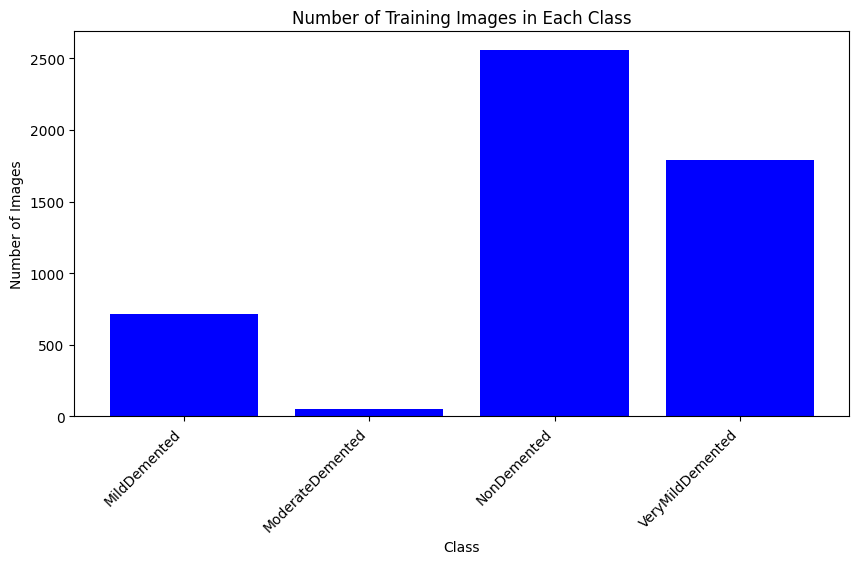

In [ ]:
# Menghitung banyaknya data dalam setiap kelas pada data training
class_counts_train = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts_train[label] += 1

# Mengambil nama kelas
class_names_train = train_dataset.classes

# Membuat grafik batang untuk data training
plt.figure(figsize=(10, 5))
plt.bar(class_names_train, class_counts_train, color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Training Images in Each Class')
plt.xticks(rotation=45, ha='right')
plt.show()


##AUGMENTASI

In [ ]:
from collections import defaultdict
import os
import random
from PIL import Image



# Fungsi untuk mendapatkan jumlah file untuk setiap kelas
def get_class_counts(dataset_path):
    class_counts = defaultdict(int)
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            class_name = root.split("/")[-1]  # Adjust this based on your directory structure
            class_counts[class_name] += 1
    return class_counts

# Fungsi untuk melakukan augmentasi hingga jumlah maksimum
def augment_data(dataset_path, max_files, augmentation_transform):
    class_counts = get_class_counts(dataset_path)
    for class_name, count in class_counts.items():
        if count < max_files:
            files_to_augment = max_files - count
            files = os.listdir(os.path.join(dataset_path, class_name))
            random.shuffle(files)
            files_to_augment = files_to_augment if files_to_augment < len(files) else len(files)

            for i in range(files_to_augment):
                file_path = os.path.join(dataset_path, class_name, files[i])
                img = Image.open(file_path)
                augmented_img = augmentation_transform(img)
                augmented_img_pil = transforms.ToPILImage()(augmented_img)
                augmented_img_pil.save(os.path.join(dataset_path, class_name, f"augmented_{i}_{files[i]}"))

# Tentukan jumlah maksimum file yang diinginkan untuk setiap kelas
max_files_per_class = 2500

# Augmentasi data training
augment_data(train_path, max_files_per_class, augmentation_transform)

# Buat objek dataset
train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Buat objek DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


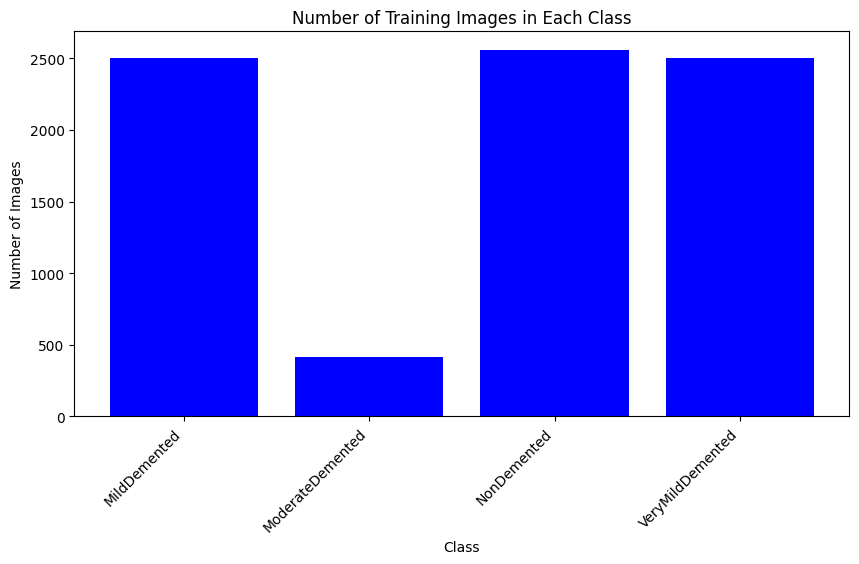

In [ ]:
# Menghitung banyaknya data dalam setiap kelas pada data training
class_counts_train = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts_train[label] += 1

# Mengambil nama kelas
class_names_train = train_dataset.classes

# Membuat grafik batang untuk data training
plt.figure(figsize=(10, 5))
plt.bar(class_names_train, class_counts_train, color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Training Images in Each Class')
plt.xticks(rotation=45, ha='right')
plt.show()

##Split Data Training menjadi data training dan data validasi

In [ ]:
from torch.utils.data import random_split

# Tentukan proporsi data validasi
validation_ratio = 0.2

# Hitung jumlah data untuk training dan validasi
total_data = len(train_dataset)
validation_size = int(validation_ratio * total_data)
train_size = total_data - validation_size

# Bagi dataset menjadi data training dan validasi
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Buat objek DataLoader untuk data training, validasi, dan test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

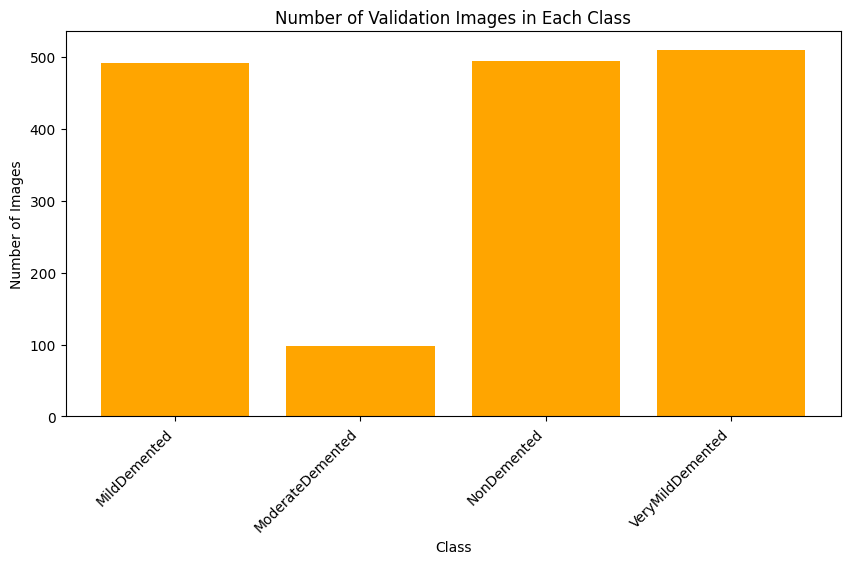

In [ ]:
# Menghitung banyaknya data dalam setiap kelas pada data validasi
class_counts_validation = [0] * len(validation_dataset.dataset.classes)
for _, label in validation_dataset:
    class_counts_validation[label] += 1

# Mengambil nama kelas
class_names_validation = validation_dataset.dataset.classes

# Membuat grafik batang untuk data validasi
plt.figure(figsize=(10, 5))
plt.bar(class_names_validation, class_counts_validation, color='orange')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Validation Images in Each Class')
plt.xticks(rotation=45, ha='right')
plt.show()



##Muat Model ResNet-101 dan Modifikasi Lapisan Output

In [ ]:
# Muat model ResNet-101
model = models.resnet101(pretrained=True)

# Ubah lapisan output untuk sesuai dengan jumlah kelas
num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Tentukan perangkat (device) untuk pelatihan (GPU atau CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Tentukan fungsi loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 62.3MB/s]


##Arsitektur Resnet101

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.counter = 0
        self.best_validation_loss = float('inf')

    def check_early_stopping(self, validation_loss):
        if validation_loss < self.best_validation_loss - self.threshold:
            self.best_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f'Early stopping...')
                return True
        return False


##Proses Training

In [ ]:
def train_and_validate(model, train_loader, validation_loader, criterion, optimizer, num_epochs, device, early_stopping_callback=None):
    train_loss_values = []
    validation_loss_values = []

    for epoch in range(num_epochs):
        model.train()

        # Pelatihan
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_loss_values.append(loss.item())
        print(f'Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{len(train_loader)}, Training Loss: {loss.item()}')

        # Validasi
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

        validation_loss /= len(validation_loader)
        validation_loss_values.append(validation_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {validation_loss}')

        # Early stopping
        if early_stopping_callback is not None and early_stopping_callback.check_early_stopping(validation_loss):
            break

    # Tampilkan grafik loss pelatihan dan validasi
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoch + 2), train_loss_values, label='Training Loss', marker='o')
    plt.plot(range(1, epoch + 2), validation_loss_values, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()




Implementasi Training max epoch = 15 dengan Early stop Patience = 3 dan threshold=0.001

Epoch 1/15, Batch 200/200, Training Loss: 0.5057528614997864
Epoch 1/15, Validation Loss: 0.6759817379713059
Epoch 2/15, Batch 200/200, Training Loss: 0.19578079879283905
Epoch 2/15, Validation Loss: 0.41413855910301206
Epoch 3/15, Batch 200/200, Training Loss: 0.016831865534186363
Epoch 3/15, Validation Loss: 0.253486165702343
Epoch 4/15, Batch 200/200, Training Loss: 0.017848452553153038
Epoch 4/15, Validation Loss: 0.2805807326361537
Epoch 5/15, Batch 200/200, Training Loss: 0.0006688850116916001
Epoch 5/15, Validation Loss: 0.27169929762370887
Epoch 6/15, Batch 200/200, Training Loss: 0.05772295966744423
Epoch 6/15, Validation Loss: 0.1848148388788104
Epoch 7/15, Batch 200/200, Training Loss: 0.9537932872772217
Epoch 7/15, Validation Loss: 0.4123120218515396
Epoch 8/15, Batch 200/200, Training Loss: 0.016126723960042
Epoch 8/15, Validation Loss: 0.35621150307357313
Epoch 9/15, Batch 200/200, Training Loss: 0.0016952409641817212
Epoch 9/15, Validation Loss: 0.15641820752993227
Epoch

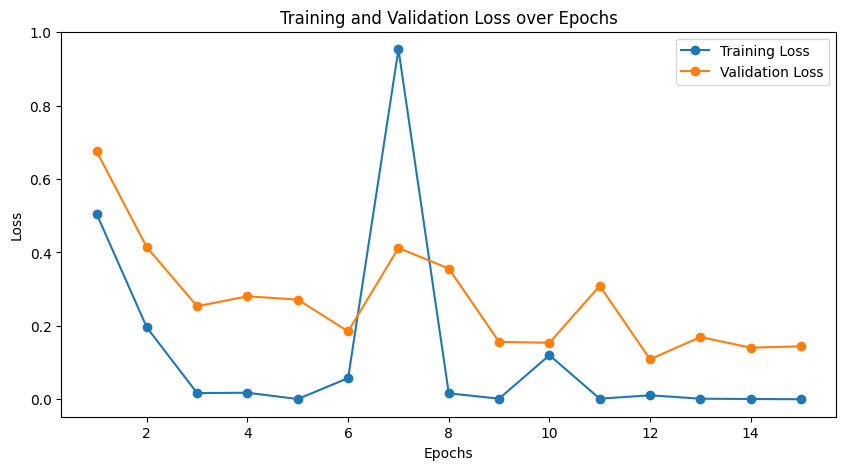

In [ ]:
# Contoh penggunaan fungsi dengan early stopping callback
num_epochs = 15
early_stopping_callback = EarlyStopping(patience=3, threshold=0.001)
train_and_validate(model, train_loader, validation_loader, criterion, optimizer, num_epochs, device, early_stopping_callback)

Implementasi Training max epoch = 15 dengan Early stop Patience = 5 dan threshold=0.001

Epoch 1/15, Batch 200/200, Training Loss: 0.0005039709503762424
Epoch 1/15, Validation Loss: 0.11728077571839095
Epoch 2/15, Batch 200/200, Training Loss: 0.002711409004405141
Epoch 2/15, Validation Loss: 0.15284654706716538
Epoch 3/15, Batch 200/200, Training Loss: 0.02306043542921543
Epoch 3/15, Validation Loss: 0.1223983926139772
Epoch 4/15, Batch 200/200, Training Loss: 0.006802733521908522
Epoch 4/15, Validation Loss: 0.10748998638708145
Epoch 5/15, Batch 200/200, Training Loss: 0.00016818993026390672
Epoch 5/15, Validation Loss: 0.17063435630872845
Epoch 6/15, Batch 200/200, Training Loss: 0.0011743585346266627
Epoch 6/15, Validation Loss: 0.13472876721061766
Epoch 7/15, Batch 200/200, Training Loss: 0.0004775626875925809
Epoch 7/15, Validation Loss: 0.20008823612704874
Epoch 8/15, Batch 200/200, Training Loss: 0.0029017776250839233
Epoch 8/15, Validation Loss: 0.18304165676236153
Epoch 9/15, Batch 200/200, Training Loss: 0.005001123063266277
Epoch 9/15, Validation Loss: 0.156426

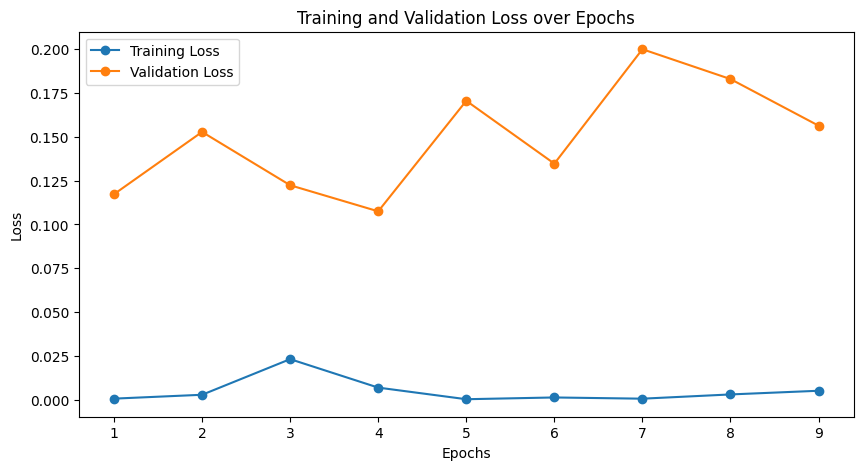

In [ ]:
# Contoh penggunaan fungsi dengan early stopping callback
num_epochs = 15
early_stopping_callback = EarlyStopping(patience=5, threshold=0.001)
train_and_validate(model, train_loader, validation_loader, criterion, optimizer, num_epochs, device, early_stopping_callback)

##Proses Testing

Iteration 1, Testing Loss: 0.46640411019325256
Iteration 2, Testing Loss: 1.106990098953247
Iteration 3, Testing Loss: 2.319671869277954
Iteration 4, Testing Loss: 2.9648427963256836
Iteration 5, Testing Loss: 3.171522617340088
Iteration 6, Testing Loss: 1.414557933807373
Iteration 7, Testing Loss: 0.041290052235126495
Iteration 8, Testing Loss: 0.0037328004837036133
Iteration 9, Testing Loss: 0.004331961739808321
Iteration 10, Testing Loss: 0.06284364312887192
Iteration 11, Testing Loss: 0.1406482309103012
Iteration 12, Testing Loss: 0.08220633864402771
Iteration 13, Testing Loss: 0.16105350852012634
Iteration 14, Testing Loss: 0.3323667049407959
Iteration 15, Testing Loss: 0.15863746404647827
Iteration 16, Testing Loss: 0.19811972975730896
Iteration 17, Testing Loss: 0.12657545506954193
Iteration 18, Testing Loss: 0.35443180799484253
Iteration 19, Testing Loss: 0.30243900418281555
Iteration 20, Testing Loss: 0.4360670745372772
Iteration 21, Testing Loss: 0.28739893436431885
Iteration

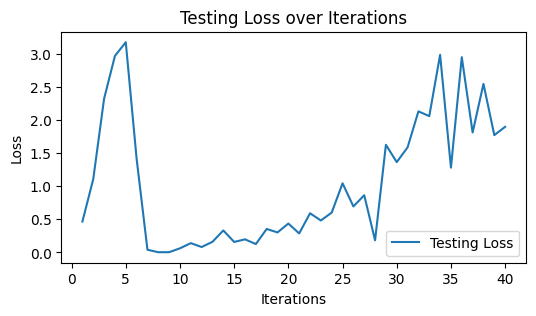

In [ ]:
test_loss_values = []
model.eval()
total_loss = 0.0
all_labels = []
all_predictions = []

with torch.no_grad():
    for iteration, (inputs, labels) in enumerate(test_loader, 1):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        test_loss_values.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        print(f"Iteration {iteration}, Testing Loss: {loss.item()}")

# Tampilkan grafik loss pengujian
plt.figure(figsize=(6, 3))
plt.plot(range(1, len(test_loss_values) + 1), test_loss_values, label='Testing Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Testing Loss over Iterations')
plt.legend()
plt.show()


##Matrix Evaluasi

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

classes = sorted(os.listdir(train_path))

# Mendapatkan metrik evaluasi untuk setiap kelas
precision_per_class = precision_score(all_labels, all_predictions, average=None)
recall_per_class = recall_score(all_labels, all_predictions, average=None)
f1_per_class = f1_score(all_labels, all_predictions, average=None)

# Menampilkan hasilnya
for i, class_name in enumerate(classes):
    # Mendapatkan indeks instance yang termasuk dalam kelas saat ini
    class_indices = [j for j, label in enumerate(all_labels) if label == i]

    # Menghitung akurasi untuk kelas saat ini
    class_accuracy = accuracy_score([all_labels[j] for j in class_indices], [all_predictions[j] for j in class_indices])

    print(f'Class: {class_name}')
    print(f'  Precision: {precision_per_class[i]:.4f}')
    print(f'  Recall: {recall_per_class[i]:.4f}')
    print(f'  F1 Score: {f1_per_class[i]:.4f}')
    print(f'  Accuracy: {class_accuracy:.4f}')
    print('---')

# Menampilkan akurasi secara keseluruhan
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Overall Accuracy: {overall_accuracy:.4f}')


Class: MildDemented
  Precision: 0.7236
  Recall: 0.4972
  F1 Score: 0.5894
  Accuracy: 0.4972
---
Class: ModerateDemented
  Precision: 0.7059
  Recall: 1.0000
  F1 Score: 0.8276
  Accuracy: 1.0000
---
Class: NonDemented
  Precision: 0.7367
  Recall: 0.9094
  F1 Score: 0.8140
  Accuracy: 0.9094
---
Class: VeryMildDemented
  Precision: 0.7536
  Recall: 0.5871
  F1 Score: 0.6600
  Accuracy: 0.5871
---
Overall Accuracy: 0.7396


##Confusion Matrix

Confusion Matrix:
[[ 89   3  54  33]
 [  0  12   0   0]
 [  5   0 582  53]
 [ 29   2 154 263]]


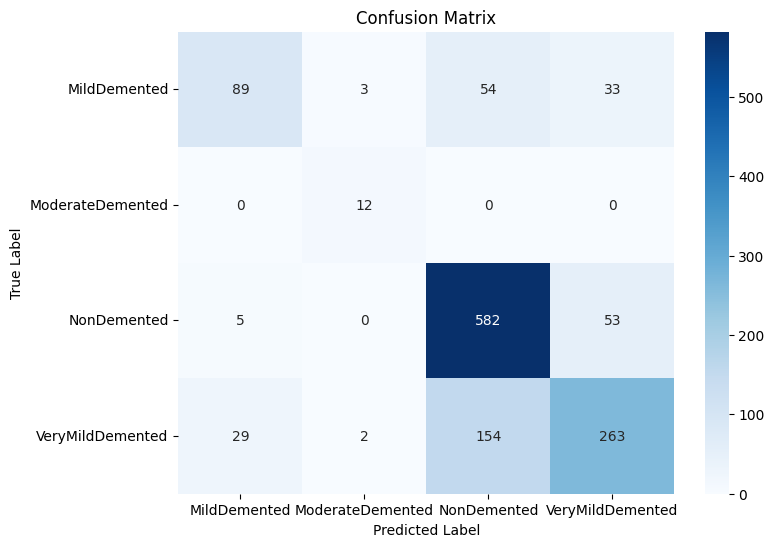

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:\n{}".format(conf_matrix))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Kelas MildDemented (0):

TP: 89
FN: 3
FP: 54
TN: 33
Kelas ModerateDemented (1):

TP: 12
FN: 0
FP: 0
TN: 0
Kelas NonDemented (2):

TP: 582
FN: 5
FP: 53
TN: 0
Kelas VeryMildDemented (3):

TP: 263
FN: 29
FP: 154
TN: 2